## The mysterious yet powerful XGBoost model 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
import xgboost as xgb
## label encoding
import sklearn
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

SUBSET = True

DIR_PATH = '../../data/'

ImportError: No module named xgboost

In [2]:
## loading data as Pandas dataframes
train_raw = pd.read_csv(os.path.join(DIR_PATH, 'train_total.csv'), 
                        header='infer', 
                        index_col='id',
                        parse_dates=['timestamp'])
test_raw = pd.read_csv(os.path.join(DIR_PATH, 'test_total.csv'), 
                       header='infer', 
                       index_col='id',
                       parse_dates=['timestamp'])

"""
macro = pd.read_csv(os.path.join(DIR_PATH, 'macro.csv'), 
                    header='infer')
"""

"\nmacro = pd.read_csv(os.path.join(DIR_PATH, 'macro.csv'), \n                    header='infer')\n"

#### Some minor feature extraction

In [3]:
## log transformation
#train_raw.loc[:, 'log_price_doc'] = np.log(train_raw['price_doc'] + 1)

## time features
train_raw.loc[:, 'year'] = train_raw.loc[:, 'timestamp'].apply(lambda x: x.strftime('%Y'))
train_raw.loc[:, 'month'] = train_raw.loc[:, 'timestamp'].apply(lambda x: x.strftime('%m'))

test_raw.loc[:, 'year'] = test_raw.loc[:, 'timestamp'].apply(lambda x: x.strftime('%Y'))
test_raw.loc[:, 'month'] = test_raw.loc[:, 'timestamp'].apply(lambda x: x.strftime('%m'))

In [39]:
train_raw.loc[:, 'sub_area'].groupby

AttributeError: 'function' object has no attribute 'sub_area'

In [51]:
np.sort(train_raw.groupby('sub_area')['sub_area'].count())

array([   1,    1,    2,    2,    3,    6,    7,    7,   15,   19,   20,
         27,   31,   34,   37,   37,   44,   49,   50,   56,   58,   60,
         60,   62,   64,   68,   72,   77,   79,   79,   81,   85,   85,
         90,   92,   94,   98,   99,  100,  100,  100,  101,  103,  105,
        111,  115,  116,  118,  119,  121,  123,  123,  126,  126,  126,
        127,  131,  131,  135,  135,  136,  137,  139,  142,  143,  147,
        147,  148,  148,  149,  152,  154,  154,  155,  158,  158,  158,
        163,  164,  165,  166,  167,  173,  174,  175,  177,  178,  180,
        182,  182,  184,  185,  188,  190,  192,  196,  197,  197,  199,
        200,  201,  206,  207,  208,  211,  213,  220,  220,  220,  224,
        230,  237,  237,  241,  247,  255,  259,  262,  264,  268,  273,
        282,  295,  297,  298,  300,  301,  305,  305,  327,  353,  362,
        410,  421,  443,  451,  496,  508,  518,  678,  679,  713,  925,
       1372, 1611, 1776])

In [62]:
top_30 = train_raw.loc[:, 'sub_area'].value_counts()[:30].index
train_raw.loc[~train_raw.loc[:,'sub_area'].isin(top_30),'sub_area'] = 'other'

### Choose the desired slice of data for the model

Pick either a subset of features or use the entire dataset

In [18]:
if SUBSET:  
    features = ['year', 'month', 'full_sq', 'life_sq', 'floor', 
                    'max_floor', 'material', 'build_year', 'num_room',
                    'kitch_sq', 'state', 'radiation_km', 'basketball_km', 'sub_area']
    train = train_raw[features]
    test = test_raw[features]
else:
    train = train_raw.copy()
    test = train_raw.copy()
    features = list(test.columns)

#### Remove certain columns from the data 

In [19]:
if 'timestamp' in features:
    train.drop('timestamp', inplace = True, axis = 1)
    test.drop('timestamp', inplace = True, axis = 1)
    features.remove('timestamp')

#### Must encode object type columns so that they can be handled by the model. This is something that R does automatically.

In [20]:
for f in train.columns:
    if train[f].dtype=='object':
        print('encoding feature: {}'.format(f))
        lbl = sklearn.preprocessing.LabelEncoder()
        train.loc[:,f] = lbl.fit_transform(train.loc[:,f])

encoding feature: year
encoding feature: month
encoding feature: sub_area


In [29]:
for f in test.columns:
    if test[f].dtype=='object':
        print('encoding feature: {}'.format(f))
        lbl = sklearn.preprocessing.LabelEncoder()
        test.loc[:,f] = lbl.fit_transform(test.loc[:,f])

encoding feature: year
encoding feature: month
encoding feature: sub_area


In [32]:
# Convert to numpy values

X_train = train.values

# price or log(price)?
Y_train = train_raw['price_doc'].values
#Y_train = train_raw['log_price_doc'].values

X_test = test.values

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(30471, 14)
(30471,)
(7662, 14)


In [33]:
size_ = 7000
X_train_sub, Y_train_sub = X_train[:-size_],  Y_train[:-size_]
X_val, Y_val = X_train[-size_:],  Y_train[-size_:]

In [34]:
# Create a validation set, with last 20% of data
dtrain = xgb.DMatrix(X_train, Y_train, feature_names=features)
dtrain_sub = xgb.DMatrix(X_train_sub, Y_train_sub, feature_names=features)
d_val = xgb.DMatrix(X_val, Y_val, feature_names=features)
dtest = xgb.DMatrix(X_test, feature_names=features)

In [35]:
# hyperparameters
xgb_params = {
    'eta': 0.02,
    'max_depth': 5,
    'subsample': .8,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

# Uncomment to tune XGB `num_boost_rounds`
sub_model = xgb.train(xgb_params, 
                      dtrain_sub, 
                      num_boost_round=2000,
                      evals=[(d_val, 'val')],
                      early_stopping_rounds=20, 
                      verbose_eval=20)

[0]	val-rmse:9.31021e+06
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:6.97478e+06
[40]	val-rmse:5.48769e+06
[60]	val-rmse:4.5652e+06
[80]	val-rmse:4.02373e+06
[100]	val-rmse:3.68006e+06
[120]	val-rmse:3.46943e+06
[140]	val-rmse:3.33147e+06
[160]	val-rmse:3.24323e+06
[180]	val-rmse:3.17528e+06
[200]	val-rmse:3.11723e+06
[220]	val-rmse:3.07856e+06
[240]	val-rmse:3.04188e+06
[260]	val-rmse:3.02237e+06
[280]	val-rmse:3.00407e+06
[300]	val-rmse:2.98132e+06
[320]	val-rmse:2.96789e+06
[340]	val-rmse:2.95018e+06
[360]	val-rmse:2.93628e+06
[380]	val-rmse:2.92348e+06
[400]	val-rmse:2.91189e+06
[420]	val-rmse:2.90458e+06
[440]	val-rmse:2.89615e+06
[460]	val-rmse:2.89094e+06
[480]	val-rmse:2.88446e+06
[500]	val-rmse:2.87954e+06
[520]	val-rmse:2.87549e+06
[540]	val-rmse:2.86525e+06
[560]	val-rmse:2.85947e+06
[580]	val-rmse:2.85531e+06
[600]	val-rmse:2.8534e+06
[620]	val-rmse:2.84626e+06
[640]	val-rmse:2.83968e+06
[660]	val-rmse:2.83485e+06
[680]	val-rmse:2.8326e+06
[700]	va

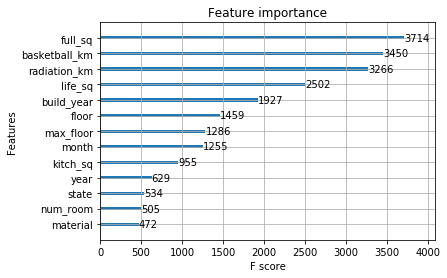

In [115]:
xgb.plot_importance(sub_model)

In [116]:
full_model = xgb.train(xgb_params,
                       dtrain, 
                       num_boost_round=sub_model.best_iteration,
                       verbose_eval=20)

In [117]:
#log_y_pred = full_model.predict(dtest)
#y_pred = np.exp(log_y_pred) - 1
y_pred = full_model.predict(dtest)

In [118]:
submit = pd.DataFrame({'id': np.array(test.index), 'price_doc': y_pred})
submit.to_csv('submission_xgb2.csv', index=False)